In [215]:
from pathlib import Path


train_val_data_path = Path().cwd() / "mri" / "Training"
test_data_path = Path().cwd() / "mri" / "Testing"

if train_val_data_path.exists() and test_data_path.exists():

    categories_paths = train_val_data_path.glob("*")
    categories = [category.name for category in categories_paths]
    
    print(f"Available categories: {categories}")

    train_imgs_paths = train_val_data_path.glob("*/*.jpg")
    test_imgs_paths = test_data_path.glob("*/*.jpg")

    train_imgs = [img.name for img in train_imgs_paths]
    test_imgs = [img.name for img in test_imgs_paths]

    print(f"\nThe size of the training and validation dataset: {len(train_imgs)}.")
    print(f"\nThe size of the test dataset: {len(test_imgs)}.")

else: 
    print("Paths do not exist.")

Available categories: ['glioma', 'meningioma', 'notumor', 'pituitary']

The size of the training and validation dataset: 5712.

The size of the test dataset: 1311.


In [216]:
from torchvision import datasets, transforms


img_resizer = transforms.Resize([250, 250])
img_tensor = transforms.ToTensor()

img_transformer = transforms.Compose([img_resizer, img_tensor])

full_training_and_val_dataset_transformed = datasets.ImageFolder(root=train_val_data_path, transform=img_transformer)
full_test_dataset_transformed = datasets.ImageFolder(root=test_data_path, transform=img_transformer)

img, cat = full_training_and_val_dataset_transformed[0]
print("--Training and validation dataset--")
print(f"Shape: {img.shape}; Type: {type(img)}; Category: {cat}", end="\n\n")

img, cat = full_test_dataset_transformed[0]
print("--Testing dataset--")
print(f"Shape: {img.shape}; Type: {type(img)}; Category: {cat}")

--Training and validation dataset--
Shape: torch.Size([3, 250, 250]); Type: <class 'torch.Tensor'>; Category: 0

--Testing dataset--
Shape: torch.Size([3, 250, 250]); Type: <class 'torch.Tensor'>; Category: 0


In [217]:
import torch
from torch.utils.data import DataLoader, random_split

seed = torch.Generator().manual_seed(42)
train_data, val_data = random_split(full_training_and_val_dataset_transformed, [0.75, 0.25], generator=seed)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)  
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(full_test_dataset_transformed, batch_size=32, shuffle=False, pin_memory=True)

In [218]:
import torch.nn as nn


class AntiTumor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),

            nn.Linear(32 * 62 * 62, 128),
            nn.ReLU(),

            nn.Linear(128, 4)
            )
        
    def forward(self, x):
        return self.layers(x)

In [219]:
model = AntiTumor()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Models utilizes: {str(device).upper()}.")

model.to(device);

Models utilizes: CUDA.


In [220]:
import torch.optim as optim


loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch: [1/10] | Average Loss: 0.7762.
Epoch: [2/10] | Average Loss: 0.3548.
Epoch: [3/10] | Average Loss: 0.2238.
Epoch: [4/10] | Average Loss: 0.1499.
Epoch: [5/10] | Average Loss: 0.0912.
Epoch: [6/10] | Average Loss: 0.0645.
Epoch: [7/10] | Average Loss: 0.0311.
Epoch: [8/10] | Average Loss: 0.0201.
Epoch: [9/10] | Average Loss: 0.0088.
Epoch: [10/10] | Average Loss: 0.0367.

Training completed.


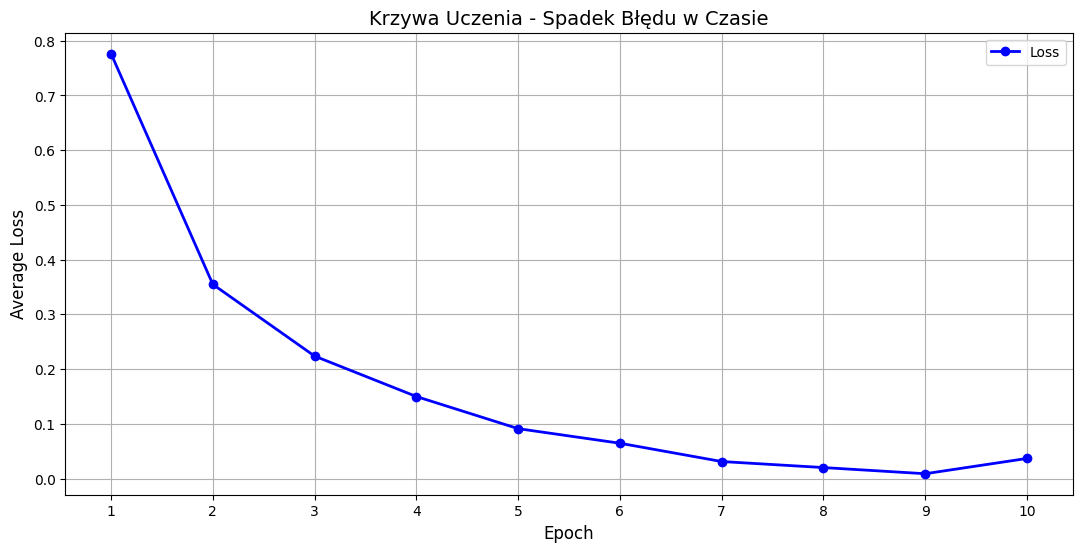

In [221]:
import matplotlib.pyplot as plt


epochs = 10
epochs_data = [epoch for epoch in range(1, epochs+1)]
avg_loss_data = []

for epoch in range(epochs):
    running_loss = 0.0
    model.train()

    for img, category in train_loader:
        img, category = img.to(device), category.to(device)

        optimizer.zero_grad()

        outputs = model(img)

        loss = loss_func(outputs, category)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    avg_loss_data.append(avg_loss)

    print(f"Epoch: [{epoch+1}/{epochs}] | Average Loss: {avg_loss:.4f}.")

print("\nTraining completed.")



plt.figure(figsize=(13, 6))

plt.plot(epochs_data, avg_loss_data, 'o-', color='blue', label='Loss', linewidth=2)

plt.title('Krzywa Uczenia - Spadek Błędu w Czasie', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.xticks(epochs_data)
plt.grid(True, linestyle='-')
plt.legend()

plt.show()

              precision    recall  f1-score   support

      glioma       0.91      0.90      0.91       329
  meningioma       0.85      0.91      0.88       334
     notumor       0.98      0.94      0.96       398
   pituitary       0.98      0.98      0.98       367

    accuracy                           0.93      1428
   macro avg       0.93      0.93      0.93      1428
weighted avg       0.93      0.93      0.93      1428



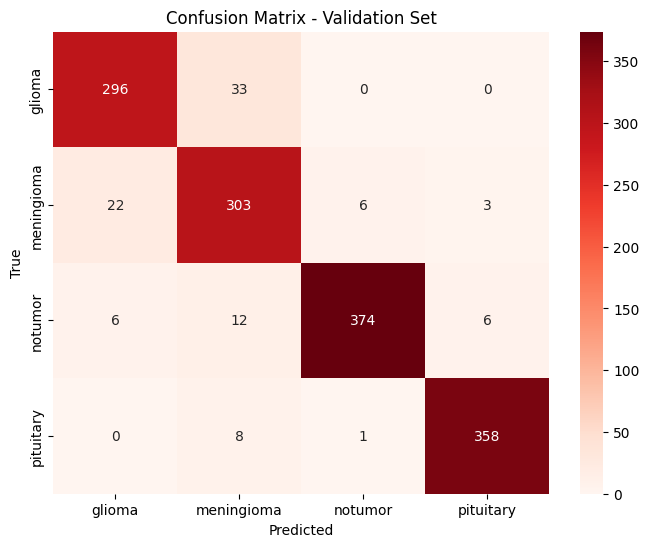

In [222]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


y_true = []
y_pred = []

model.eval()

with torch.no_grad():
    for img, category in val_loader:
        img = img.to(device)

        results = model(img)
        results_list, result = torch.max(results, 1)

        y_true.extend(category)
        y_pred.extend(result.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=full_training_and_val_dataset_transformed.classes))



plt.figure(figsize=(8, 6))

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=full_training_and_val_dataset_transformed.classes, 
            yticklabels=full_training_and_val_dataset_transformed.classes)

plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

              precision    recall  f1-score   support

      glioma       0.92      0.88      0.90       300
  meningioma       0.85      0.90      0.87       306
     notumor       0.98      0.98      0.98       405
   pituitary       0.99      0.97      0.98       300

    accuracy                           0.94      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



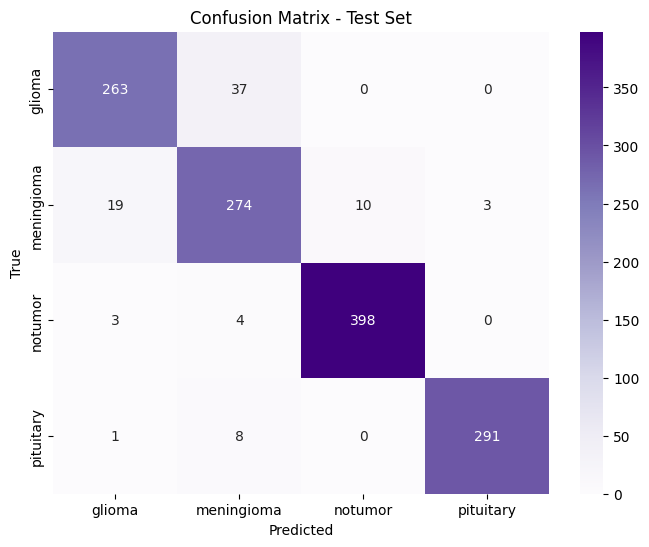

In [223]:
y_true = []
y_pred = []

model.eval()

with torch.no_grad():
    for img, category in test_loader:
        img = img.to(device)

        results = model(img)
        results_list, result = torch.max(results, 1)

        y_true.extend(category)
        y_pred.extend(result.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=full_test_dataset_transformed.classes))



plt.figure(figsize=(8, 6))

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=full_test_dataset_transformed.classes, 
            yticklabels=full_test_dataset_transformed.classes)

plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()